In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import cv2
from tqdm import tqdm

In [3]:
RANDOM_SEED = 42

In [4]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
#sample = pd.read_csv('datatset/sample.csv')

# Loading the data files into pandas dataframe type

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
le_class = LabelEncoder()
train_df['Class'] = le_class.fit_transform(train_df['Class'])

# Giving different class name a numerical variable

In [7]:
train_images_path = os.path.join('dataset/'+'Train/')
train_images = os.listdir(train_images_path)

test_images_path = os.path.join('dataset/'+'Test/')
test_images = os.listdir(test_images_path)

# Listing train and test images

In [8]:
def create_train_data(train_images_path,train_images,train_df):
    train_img,target = [],[]

    for image in tqdm(train_images):
        img = cv2.imread(train_images_path+image)
        img = cv2.resize(img,(128,128))

        train_img.append(img)

        label = train_df.loc[train_df['ID']==image,'Class'].values[0]
        target.append(label)

    return np.array(train_img),np.array(target)                ##  creating a trainable dataset (numpy) for model training

def create_test_data(test_images_path,test_images,test_df):
    test_img = []

    for image in tqdm(test_images):
        img = cv2.imread(test_images_path+image)
        img = cv2.resize(img,(128,128))

        test_img.append(img)

    return np.array(test_img)            ## preparing images for testing similar to train images
    

In [9]:
x_images_train,target = create_train_data(train_images_path,train_images,train_df)
x_test_images = create_test_data(test_images_path,test_images,test_df)

100%|██████████| 6636/6636 [00:05<00:00, 1235.60it/s]


In [10]:
print("Train Images:",len(x_images_train))
print("Target Labels:",len(target))
print("Test Images:",len(x_test_images))

Train Images: 19906
Target Labels: 19906
Test Images: 6636


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train,x_test,y_train,y_test = train_test_split(x_images_train,target,test_size=0.2,random_state=RANDOM_SEED,stratify=target)

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255,      
                                    horizontal_flip=True,
                                    shear_range=0.2,
                                    zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1/255)

#creating Data Generators for our Test and Train Data

In [15]:
train_datagen.fit(x_train)
test_datagen.fit(x_test)
test_datagen.fit(x_test_images)

In [16]:
from keras.utils import to_categorical

In [17]:
train_set = train_datagen.flow(x_train,
                            to_categorical(y_train,3),
                            batch_size=256)
test_set = test_datagen.flow(x_test,
                            to_categorical(y_test,3),
                            batch_size=256)                            

#final preparation of data for model training                            

In [18]:
from keras.applications import ResNet50V2,VGG16
from keras.layers import Dense,Dropout,BatchNormalization,Flatten
from keras.models import Sequential

In [19]:
model_tr = VGG16(include_top=False,
                    weights='imagenet',
                    input_shape=(128,128,3),
                    pooling=None)
model_tr.trainable = False                

In [20]:
model = Sequential()
model.add(model_tr)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')


In [21]:
from livelossplot import PlotLossesKeras

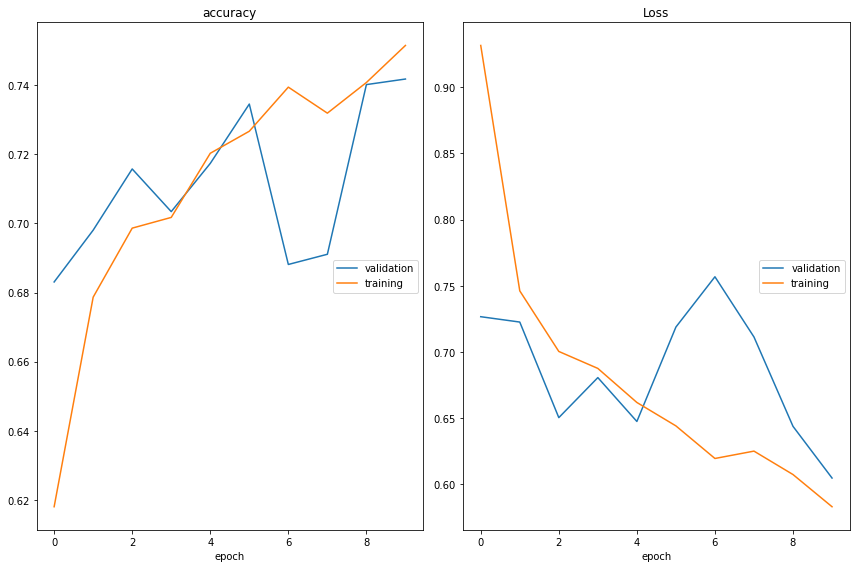

accuracy
	validation       	 (min:    0.683, max:    0.742, cur:    0.742)
	training         	 (min:    0.618, max:    0.752, cur:    0.752)
Loss
	validation       	 (min:    0.605, max:    0.757, cur:    0.605)
	training         	 (min:    0.583, max:    0.932, cur:    0.583)


In [22]:
h = model.fit(train_set,
            validation_data = test_set,
            steps_per_epoch=train_set.n//256,
            validation_steps=test_set.n//256,
            callbacks=[PlotLossesKeras()],
            epochs=10
            )

In [27]:
y_pred = model.predict(x_test_images)
y_pred = [np.argmax(k) for k in y_pred]
y_pred = le_class.inverse_transform(y_pred)

In [29]:
sub = pd.DataFrame({'Class':y_pred,'ID':test_images})

In [30]:
sub.to_csv('Submission.csv',index=False)